In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Introduction to Realtime Anomaly Detectiontion
In this notebook, we introduce the `detect_anomaly_realtime` method. You'll learn how to quickly start using this new endpoint and understand its key differences from the historical forecast endpoint. The new features include:
* Have more flexibility and control over the anomaly detection process
* Conduct univariate/ multivariate anomaly detection
* Detect Anomaly on stream data

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/realtime-anomaly-detection/01_quickstart')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/realtime-anomaly-detection/01_quickstart.ipynb)

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

## 1. Dataset
In this notebook, we use an minute level server machine monitoring time series for demonstration. Here, we use this example simulates a real-world streaming data scenerio, where the goal is to detect anomalies in real time, such as when the server experiences a failure or downtime.

In [ ]:
df = pd.read_csv('../../../assets/machine-1-1.csv', parse_dates=['ts'])

We observe that the time series remains stable during the initial period; however, a spike occurs in the last 20 steps, indicating anomalous behavior. Our goal is to capture this abnormal jump as soon as it appears. Let's see how the real-time anomaly detection method performs in this scenario!

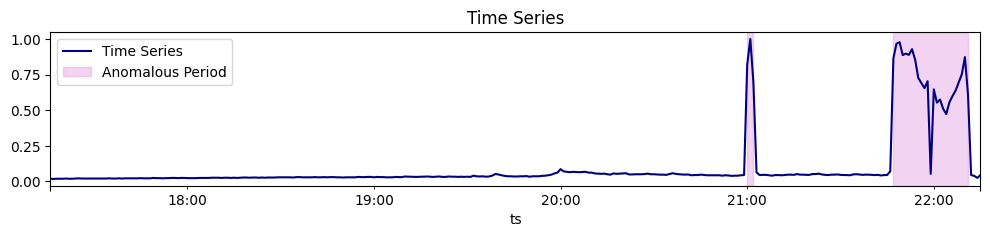

In [ ]:
#| echo: false
import matplotlib.pyplot as plt
ax = df.tail(300).plot(x='ts', y='y', color = 'navy', title='Time Series', figsize=(12, 2))
plt.axvspan('2020-02-01 21:00:00', '2020-02-01 21:02:00', color='orchid', alpha=0.3, label='Anomalous Period')
plt.axvspan('2020-02-01 21:47:00', '2020-02-01 22:11:00', color='orchid', alpha=0.3)
ax.legend(['Time Series', 'Anomalous Period'])
plt.show()

## 2. Detect anomalies in Realtime
The `detect_anomaly_realtime` method detect anomalies in a time series leveraging TimeGPT's forecast power. It leverages the forecast error in deciding the anomalous step. Therefore, you need to specify and tune the parameters like that of the forecast method. This function will return a dataframe that contains anomaly flags and anomaly score(its absolute value indicates abnoamlity of the step)
To make a detection, set the following parameters:

- `df`: A pandas DataFrame containing the time series data.
- `time_col`: The column that identifies the datestamp.
- `target_col`: The variable to forecast.
- `h`: Horizons is the number of steps ahead to make forecast.
- `freq`: The frequency of the time series in Pandas format.
- `level`: The confidence level for anomaly detection, default to 99%
- `detection_size`: The number of steps to analyze for anomaly at the end of time series.

In [ ]:
anomaly_online = nixtla_client.detect_anomalies_realtime(
    df,
    time_col='ts',                  
    target_col='y',                 
    freq='m',                       # Specify the frequency of the data
    h=10,                           # Specify the forecast horizon
    level=99,                       # Set the confidence level for anomaly detection
    detection_size=100)             # How many steps you want for analyzing anomalies
anomaly_online.tail()


INFO:nixtla.nixtla_client:Validating inputs...
/Users/yibeihu/anaconda3/envs/test/lib/python3.12/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


,unique_id,ts,y,TimeGPT,anomaly,anomaly_score,TimeGPT-hi-99,TimeGPT-lo-99
95,machine-1-1_y_29,2020-02-01 22:11:00,0.606017,0.481175,True,8.012249,0.523800,0.438550
96,machine-1-1_y_29,2020-02-01 22:12:00,0.044413,0.551303,True,-30.163446,0.593928,0.508678
97,machine-1-1_y_29,2020-02-01 22:13:00,0.038682,0.538656,True,-29.745493,0.581281,0.496031
98,machine-1-1_y_29,2020-02-01 22:14:00,0.024355,0.534585,True,-30.365294,0.577210,0.491960
99,machine-1-1_y_29,2020-02-01 22:15:00,0.044413,0.551937,True,-30.201727,0.594561,0.509312


> 📘 In this example, we use a detection size of 100 to illustrate the anomaly detection process. In practice, using a smaller detection size and running the detection more frequently improves granularity and enables more timely identification of anomalies as they occur.

From the plot, we observe that both anomalous periods were detected right as they arose. For further ideas on improving detection accuracy and customizing anomaly detection, please proceed to the next sections for exploration.

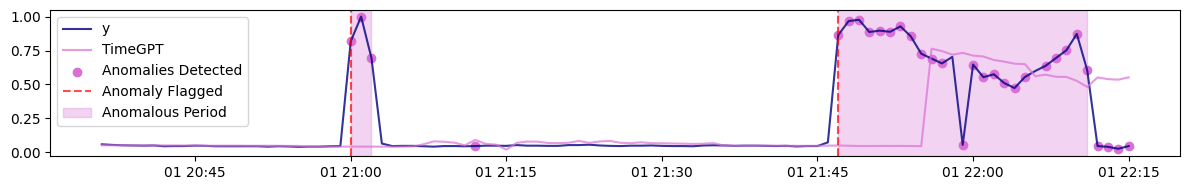

In [ ]:
#| echo: false
plt.figure(figsize=(12, 2))
plt.plot(anomaly_online['ts'], anomaly_online['y'], label='y', color='navy', alpha=0.8)
plt.plot(anomaly_online['ts'], anomaly_online['TimeGPT'], label='TimeGPT', color='orchid', alpha=0.7)
plt.scatter(anomaly_online.loc[anomaly_online['anomaly'], 'ts'], anomaly_online.loc[anomaly_online['anomaly'], 'y'], color='orchid', label='Anomalies Detected')
for t in ['2020-02-01 21:00:00', '2020-02-01 21:47:00']:
    plt.axvline(pd.to_datetime(t), color='red', linestyle='--', alpha=0.7, label='Anomaly Behavior Captured' if t == '2020-02-01 21:00:00' else None)

plt.axvspan('2020-02-01 21:00:00', '2020-02-01 21:02:00', color='orchid', alpha=0.3, label='Anomalous Period')
plt.axvspan('2020-02-01 21:47:00', '2020-02-01 22:11:00', color='orchid', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

For an in-depth analysis of the `detect_anomaly_realtime` method, please refer to tutorial.